In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("/data/ferplus/train", transform=transform)
val_data = datasets.ImageFolder("/data/ferplus/val", transform=transform)
test_data = datasets.ImageFolder("/data/ferplus/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
num_classes = len(class_names)
print("✅ Classes:", class_names)


✅ Classes: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# VGG16 + SE + Custom Classifier
class VGG16_SE_Custom(nn.Module):
    def __init__(self, num_classes=8):
        super(VGG16_SE_Custom, self).__init__()
        base = models.vgg16(pretrained=True)
        self.features = base.features  # convolutional backbone

        # Freeze backbone
        for param in self.features.parameters():
            param.requires_grad = True

        self.se = SEBlock(512)  # 512 is the output of VGG16 last conv layer

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16_SE_Custom(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {trainable:,} / {total:,}")


Trainable params: 40,967,496 / 40,967,496


In [ ]:


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    model.train()
    return correct / total


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 1.0692 | Train Acc: 0.6156 | Val Acc: 0.7446
Epoch 2/10 | Avg Loss: 0.5882 | Train Acc: 0.7937 | Val Acc: 0.7953
Epoch 3/10 | Avg Loss: 0.3829 | Train Acc: 0.8675 | Val Acc: 0.8189
Epoch 4/10 | Avg Loss: 0.2579 | Train Acc: 0.9119 | Val Acc: 0.8205
Epoch 5/10 | Avg Loss: 0.1704 | Train Acc: 0.9435 | Val Acc: 0.8222
Epoch 6/10 | Avg Loss: 0.1141 | Train Acc: 0.9631 | Val Acc: 0.8295
Epoch 7/10 | Avg Loss: 0.0877 | Train Acc: 0.9738 | Val Acc: 0.8206
Epoch 8/10 | Avg Loss: 0.0729 | Train Acc: 0.9787 | Val Acc: 0.8293
Epoch 9/10 | Avg Loss: 0.0612 | Train Acc: 0.9825 | Val Acc: 0.8278
Epoch 10/10 | Avg Loss: 0.0537 | Train Acc: 0.9847 | Val Acc: 0.8304


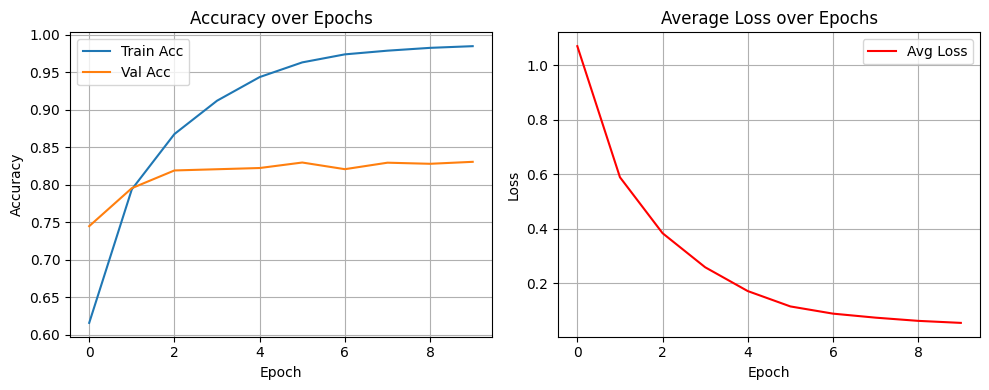

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.8192

🔍 Classification Report:

              precision    recall  f1-score   support

       angry       0.80      0.74      0.77       898
    contempt       0.93      0.98      0.96       898
     disgust       0.93      0.97      0.95       898
        fear       0.86      0.90      0.88       898
       happy       0.82      0.79      0.81       898
     neutral       0.71      0.67      0.69       898
         sad       0.74      0.67      0.70       898
     suprise       0.77      0.85      0.81       898

    accuracy                           0.82      7184
   macro avg       0.82      0.82      0.82      7184
weighted avg       0.82      0.82      0.82      7184



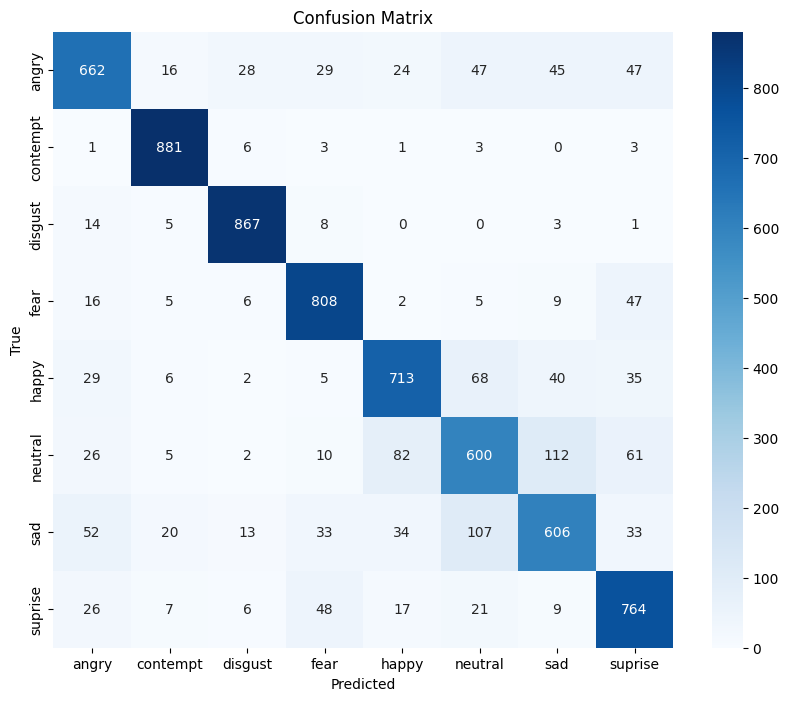

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# ✅ Classification Report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#Full Model Training

Epoch 1/10 | Avg Loss: 0.8057 | Train Acc: 0.7127 | Val Acc: 0.8354
Epoch 2/10 | Avg Loss: 0.3834 | Train Acc: 0.8645 | Val Acc: 0.8688
Epoch 3/10 | Avg Loss: 0.2489 | Train Acc: 0.9143 | Val Acc: 0.8917
Epoch 4/10 | Avg Loss: 0.1818 | Train Acc: 0.9371 | Val Acc: 0.8979
Epoch 5/10 | Avg Loss: 0.1357 | Train Acc: 0.9528 | Val Acc: 0.8942
Epoch 6/10 | Avg Loss: 0.1131 | Train Acc: 0.9617 | Val Acc: 0.8925
Epoch 7/10 | Avg Loss: 0.0919 | Train Acc: 0.9695 | Val Acc: 0.9003
Epoch 8/10 | Avg Loss: 0.0829 | Train Acc: 0.9721 | Val Acc: 0.8943
Epoch 9/10 | Avg Loss: 0.0727 | Train Acc: 0.9746 | Val Acc: 0.8964
Epoch 10/10 | Avg Loss: 0.0684 | Train Acc: 0.9771 | Val Acc: 0.8985


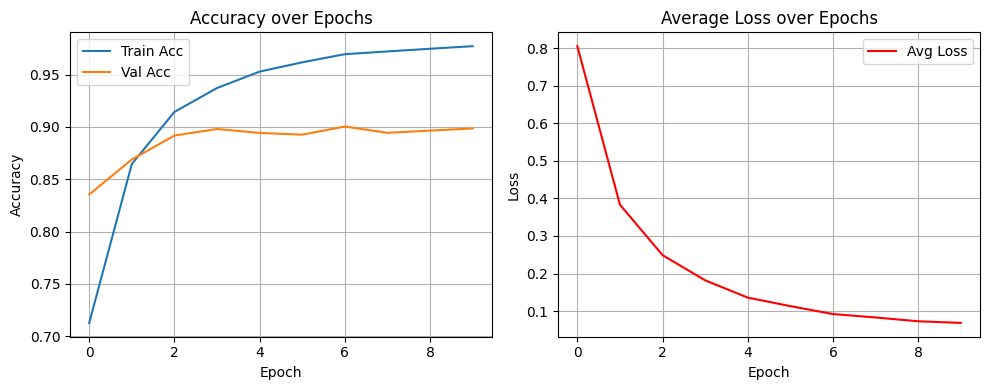

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.8963

🔍 Classification Report:

              precision    recall  f1-score   support

       angry       0.94      0.82      0.88       898
    contempt       0.98      0.98      0.98       898
     disgust       0.94      0.99      0.97       898
        fear       0.92      0.96      0.94       898
       happy       0.93      0.90      0.91       898
     neutral       0.81      0.78      0.79       898
         sad       0.80      0.83      0.81       898
     suprise       0.87      0.91      0.89       898

    accuracy                           0.90      7184
   macro avg       0.90      0.90      0.90      7184
weighted avg       0.90      0.90      0.90      7184



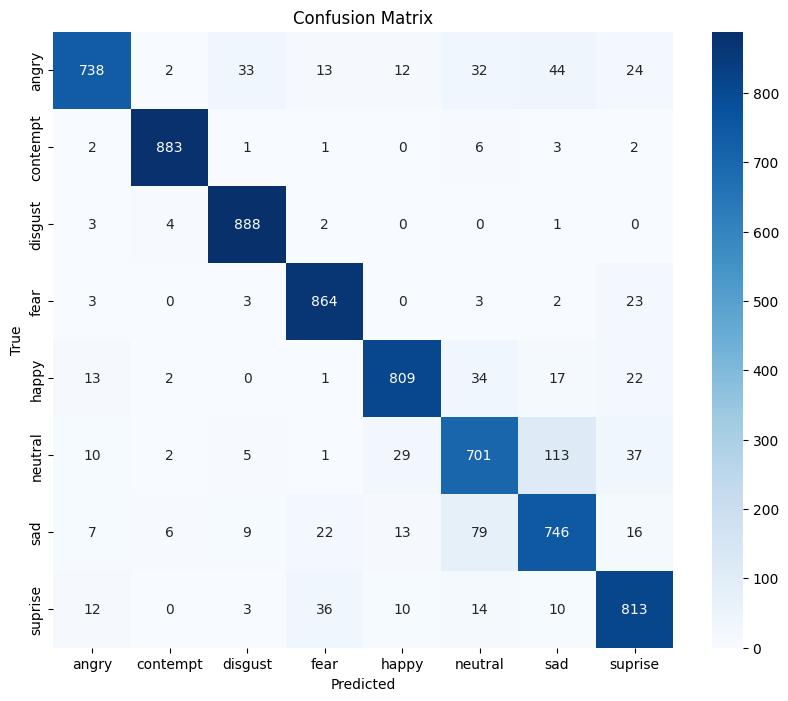

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# ✅ Classification Report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
